## This file contains one commented process of loading, preparing and splitting one dataset and creating, training and evaluating one model.

### More training with different hyperparameters is in other files.

In [1]:
from imports import *

2024-06-27 21:09:58.468030: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 21:09:58.489806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 21:09:58.489823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 21:09:58.489837: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 21:09:58.493911: I tensorflow/core/platform/cpu_feature_g

In [2]:
sys.path.append('src')
from process_data import DataProcessor
from vanilla_transformer import Transformer
from visualize_data import Visualizer
from train_model import ModelTrainer
from load_data import DataLoader
model_trainer = ModelTrainer()
data_processor = DataProcessor()
visualizer = Visualizer()
data_loader = DataLoader()

## 0. Data loading

This file works with forex EURUSD currency pair with candles measured every 15 minutes.

In [3]:
data, pip_factor= data_loader.load_eurusd_15min()

In [4]:
data.head()

,time,open,high,low,close,volume
0,2020-05-03 21:15,1.09709,1.09726,1.09688,1.09694,29
1,2020-05-03 21:30,1.09690,1.09723,1.09676,1.09696,14
2,2020-05-03 21:45,1.09700,1.09708,1.09696,1.09704,34
3,2020-05-03 22:00,1.09705,1.09736,1.09675,1.09676,1067
4,2020-05-03 22:15,1.09677,1.09677,1.09599,1.09603,1190


## 1. Data preparation

In [5]:
data = data[data.shape[0]//2:]

Model will be trained on input sequences of length 32 (eight hours) and target sequences of length 8 (two hours)

In [6]:
input_seq_len = 32
output_seq_len = 8

# 60:20:20 split for training validation test sets
train_pct = 0.6
val_pct = 0.2

1.a Replace prices with their filtered versions

In [7]:
b, a = butter(5, 1/8, btype='low', analog=False)
data['bw_open'] = filtfilt(b, a, data['open'])
data['bw_high'] = filtfilt(b, a, data['high'])
data['bw_low'] = filtfilt(b, a, data['low'])
data['bw_close'] = filtfilt(b, a, data['close'])

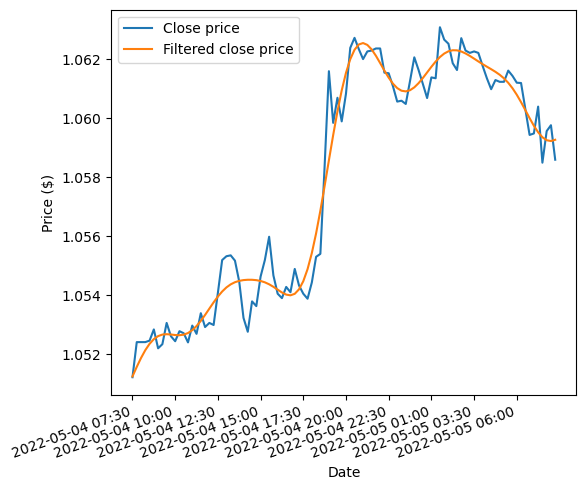

In [8]:
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)

ax1.plot(data['time'][:100], data['open'][:100], label='Close price')
ax1.plot(data['time'][:100], data['bw_open'][:100], label='Filtered close price')

every_nth = 10
xticks = data['time'][:100:every_nth]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=20, ha='right');
ax1.legend()
ax1.set_ylabel('Price ($)')
ax1.set_xlabel('Date');

Note: Although model's target sequences will be made of the filtered price instead of the original price, the evaluation will be computed with the original (so the evaluation is done on real-world data).

1.b Add technical indicators: Relative Strength Index, Williams %R

In [9]:
data['rsi_close_14'] = abstract.RSI(data, timeperiod=7, price='close')
data['willr_close_42'] = abstract.WILLR(data, timeperiod=42, price='close')

In [10]:
data.dropna(how='any', axis=0, inplace=True)

In [11]:
list(data.columns)

['time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'bw_open',
 'bw_high',
 'bw_low',
 'bw_close',
 'rsi_close_14',
 'willr_close_42']

In [12]:
data, _ = data_processor.normalize_custom(data, train_pct, ['volume', 'rsi_close_14', 'willr_close_42'])

In [13]:
# save data for future evaluation
target_time = data[['time', 'bw_close', 'close']]

Instead of price, use change of price from one time step to following time step

In [14]:
data = data_processor.diff_features(data, ['close', 'bw_open', 'bw_high', 'bw_low', 'bw_close'])


data.dropna(how='any', axis=0, inplace=True)

/tmp/ipykernel_20446/84832590.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(how='any', axis=0, inplace=True)


In [15]:
min(data['bw_close']), max(data['bw_close']), np.median(data['bw_close'])

(-0.0019105034263933174, 0.002587228233668304, 2.1907770604290278e-06)

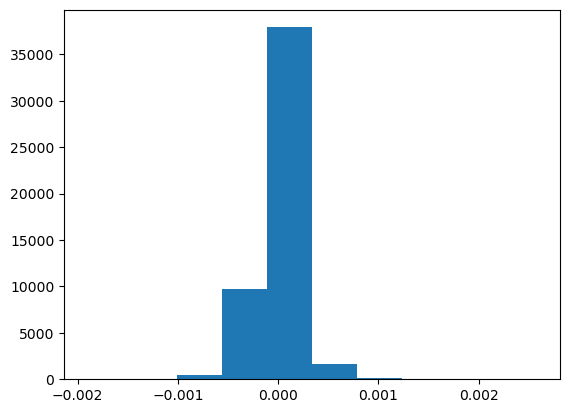

In [16]:
# what values are we curently working with?
plt.hist(data['bw_close']);

To prevent from having such small values, use pips.

In [17]:
data.loc[:, 'close'] *= pip_factor
data.loc[:, 'bw_close'] *= pip_factor
data.loc[:, 'bw_open'] *= pip_factor
data.loc[:, 'bw_high'] *= pip_factor
data.loc[:, 'bw_low'] *= pip_factor
# data.loc[:, 'diff_bw_close'] *= pip_factor

In [18]:
# save transformed data for future evaluation
target = data[['close', 'bw_close']]

In [19]:
data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)

/tmp/ipykernel_20446/4177561520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)


## 2. Split data

In [20]:
Xdata, ydata = model_trainer.create_Xy_data(data, target, input_seq_len, output_seq_len)

In [21]:
np.random.seed(42)
shuffled_indices = np.random.permutation(Xdata.shape[0])
Xdata = Xdata[shuffled_indices]
ydata = ydata[shuffled_indices]

In [22]:
Xtrain_time, ytrain_c, Xval_time, yval_c, Xtest_time, ytest_c = model_trainer.split_data(Xdata, ydata, train_pct, val_pct)

In [23]:
# discard time column
Xtrain = (Xtrain_time[:, :, 1:]).astype(np.float64)
Xval = (Xval_time[:, :, 1:]).astype(np.float64)
Xtest = (Xtest_time[:, :, 1:]).astype(np.float64)

# discard original close price column, keep only filtered close price column
ytrain = ytrain_c[:, :, 1:]
yval = yval_c[:, :, 1:]
ytest = ytest_c[:, :, 1:]

In [24]:
# parameters of the transformer model
config = {
    'input_seq_len': input_seq_len,
    'output_seq_len': output_seq_len,
    'multihead_attn_heads': 4,
    'd_k': 32,
    'd_v': 32,
    'd_ff': 32,
    'd_out': ytrain.shape[-1],
    'd_model': 32,
    'encoder_layers': 1,
    'decoder_layers': 1,
    'dropout_rate': 0.1,
    'activation': 'relu',
    'batch_size': 32,
}

## 3. Train/load model

In [25]:
epochs = 30

path = 'saved_models/tf-thesis.h5'

# model was trained beforehand, and is in directory saved_models/
model = model_trainer.load_model_transformer(path, Xtest, config)

#model = Transformer(config)

2024-06-27 21:10:07.984929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9314 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [26]:
# model, best_epoch, train_losses, val_losses = model_trainer.train_model_transformer(Xtrain, ytrain, Xval, yval, path, epochs, model, 1e-3, config, Xtest)

In [27]:
with tf.device('/CPU:0'):
    pred = model(Xtest, target=None, training=False)

## 4. Evaluation

In [28]:
# for illustration the following plot shows four input and output sequences

In [29]:
def find_last_row_input_sequence(input_sequences, input_seq_idx, target):
    time_tmp = input_sequences[input_seq_idx][-1][0]  # time of last candle in input sequence
    return target[target['time'] == time_tmp].index[0]

def rcst_candles(pred, target, idx, pred_candles, output_seq_len):
    close_tmp = target.loc[idx][1]
    for i in range(output_seq_len):
        close_tmp += pred[0][i][0].numpy()
        pred_candles.loc[len(pred_candles)] = ['', close_tmp, 420]
    return pred_candles

idx0, idx1, idx2, idx3 = random.sample(range(0, 100 + 1), 4)
pred0 = model(Xtest[idx0:idx0+1, :, :], None, training=False)
pred1 = model(Xtest[idx1:idx1+1, :, :], None, training=False)
pred2 = model(Xtest[idx2:idx2+1, :, :], None, training=False)
pred3 = model(Xtest[idx3:idx3+1, :, :], None, training=False)

In [30]:
pd.options.mode.chained_assignment = None
last_row_idx = find_last_row_input_sequence(Xtest_time, idx0, target_time)
pred_candles_0 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx]
real_candles_0 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx+output_seq_len]
pred0 /= pip_factor
pred_candles_0 = rcst_candles(pred0, target_time, last_row_idx, pred_candles_0, output_seq_len)

last_row_idx = find_last_row_input_sequence(Xtest_time, idx1, target_time)
pred_candles_1 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx]
real_candles_1 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx+output_seq_len]
pred1 /= pip_factor
pred_candles_1 = rcst_candles(pred1, target_time, last_row_idx, pred_candles_1, output_seq_len)

last_row_idx = find_last_row_input_sequence(Xtest_time, idx2, target_time)
pred_candles_2 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx]
real_candles_2 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx+output_seq_len]
pred2 /= pip_factor
pred_candles_2 = rcst_candles(pred2, target_time, last_row_idx, pred_candles_2, output_seq_len)

last_row_idx = find_last_row_input_sequence(Xtest_time, idx3, target_time)
pred_candles_3 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx]
real_candles_3 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx+output_seq_len]
pred3 /= pip_factor
pred_candles_3 = rcst_candles(pred3, target_time, last_row_idx, pred_candles_3, output_seq_len)

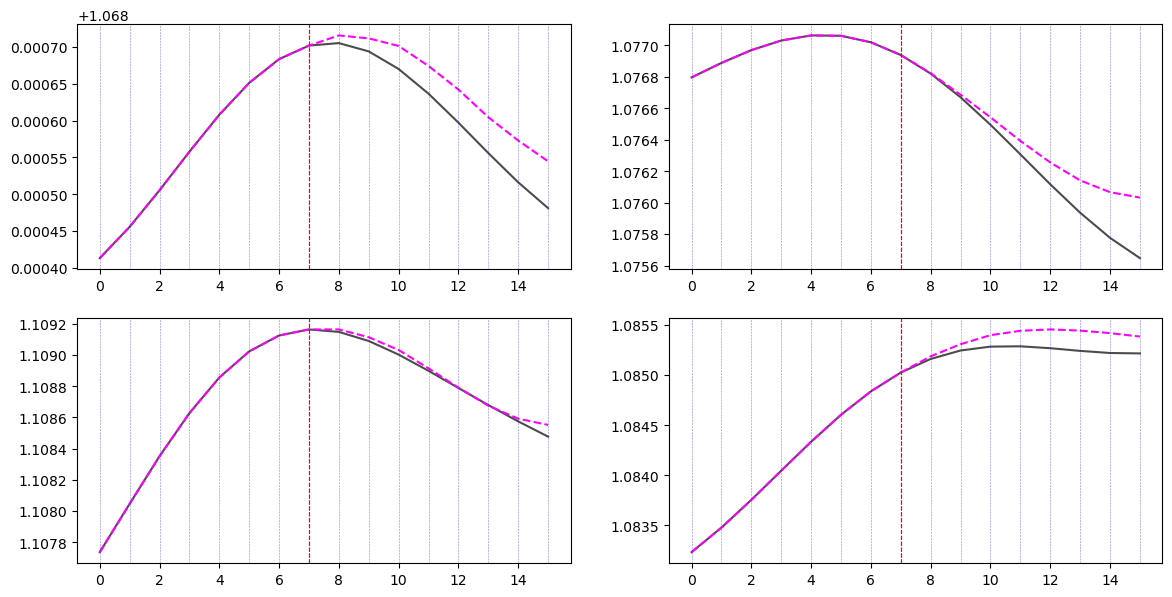

In [31]:
visualizer.plot_real_predicted_sequences('bw_close', [real_candles_0, real_candles_1, real_candles_2, real_candles_3], [pred_candles_0, pred_candles_1, pred_candles_2, pred_candles_3], output_seq_len)

### 4a. binary classification 

1. the target here was pip, so we will sum all pips in target and predicted sequence to determine whether price increased on decreased
2. then create classes for binary classification and plot pie plots to show many times price increased and decreased in testing data
3. then calculate accuracy, precision, recall, f1 score

In [32]:
real_price_movement = list(data_processor.sum_along_seq_dim(ytest_c[:,:,0]))
pred_price_movement = list(data_processor.sum_along_seq_dim(pred[:,:,0]))

In [33]:
#real_classes, pred_classes = create_classification_classes(real_price_movement, pred_price_movement)
real_classes = data_processor.create_binary_classification_classes(real_price_movement, 0.0)
pred_classes = data_processor.create_binary_classification_classes(pred_price_movement, 0.0)

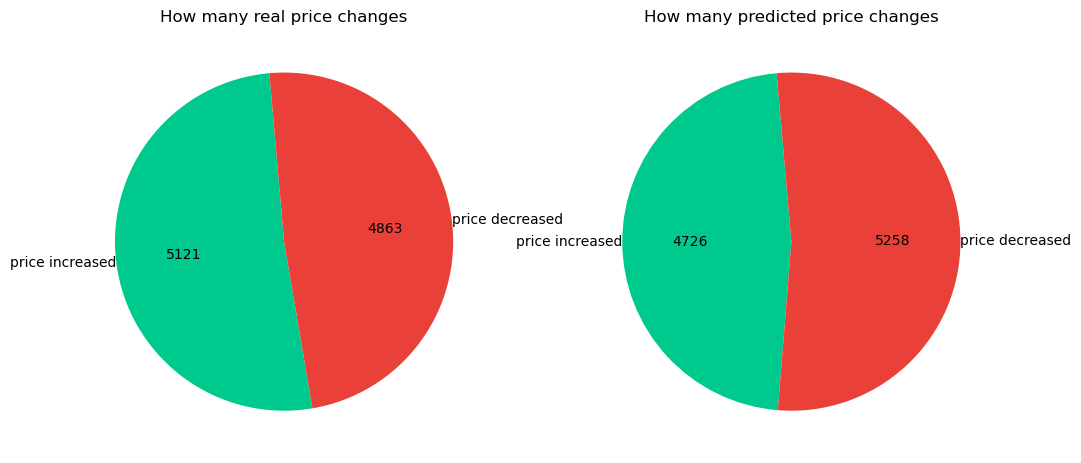

In [34]:
visualizer.pie_number_of_price_movements_binary(real_classes, pred_classes)

In [35]:
accuracy_0, precision_0, recall_0, f1_0 = data_processor.create_metrics_from_classes_binary(real_classes, pred_classes)
visualizer.create_metrics_df(accuracy_0, precision_0, recall_0, f1_0)

,Metric,Value
0,Accuracy,0.749299
1,Precision,0.776978
2,Recall,0.717047
3,F1 Score,0.745811


### 4.b further evaluation
* idea: if we predict that price will change not significantly (for example price will change 0.05 %), we will classify this case with third class
1. plot histograms to see how price changes are distributed
2. pick a threshold: if price changes for less than threshold and more than -1*threshold, assign this data point to the third class
3. compute metrics for different thresholds and plot them

4. if price change is inside the threshold interval, discard this data point from both predicted data and real data
5. do binary classification only on data, that predicted significant price change
6. compute metrics for different thresholds and plot them

In [36]:
real_price_movement_pct = data_processor.find_pct_movements(Xtest_time, target_time, real_price_movement, pip_factor)
pred_price_movement_pct = data_processor.find_pct_movements(Xtest_time, target_time, pred_price_movement, pip_factor)

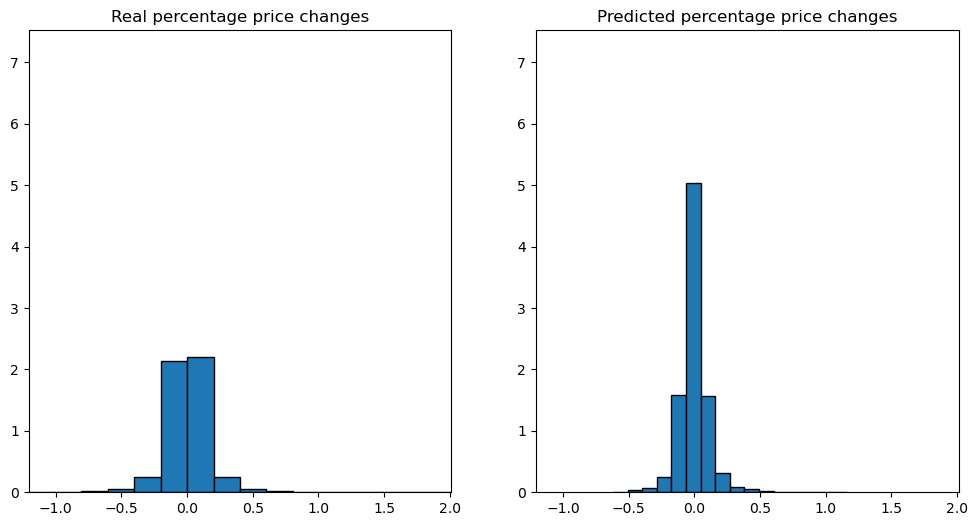

In [37]:
visualizer.plot_two_histograms(real_price_movement_pct, pred_price_movement_pct)

In [38]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

accuracies_ternary = []
precisions_ternary = []
recalls_ternary = []
f1s_ternary = []

accuracies_binary = []
precisions_binary = []
recalls_binary = []
f1s_binary = []

start = 0
end = 1
thresholds = np.linspace(start, end, 100)

for threshold in thresholds:  # threshold == 1 means one percent change in price
    real_ternary_classes = data_processor.create_ternary_classification_classes(real_price_movement_pct, threshold, 0.0)
    pred_ternary_classes = data_processor.create_ternary_classification_classes(pred_price_movement_pct, threshold, 0.0)
    accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_ternary(real_ternary_classes, pred_ternary_classes)
    accuracies_ternary.append(accuracy)
    precisions_ternary.append(precision)
    recalls_ternary.append(recall)
    f1s_ternary.append(f1)

    real_price_movement_pct_reduced, pred_price_movement_pct_reduced = data_processor.discard_little_price_movements(pred_ternary_classes, real_price_movement_pct, pred_price_movement_pct)
    real_tmp = data_processor.create_binary_classification_classes(real_price_movement_pct_reduced, 0.0)
    pred_tmp = data_processor.create_binary_classification_classes(pred_price_movement_pct_reduced, 0.0)
    accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_binary(real_tmp, pred_tmp)
    accuracies_binary.append(accuracy)
    precisions_binary.append(precision)
    recalls_binary.append(recall)
    f1s_binary.append(f1)

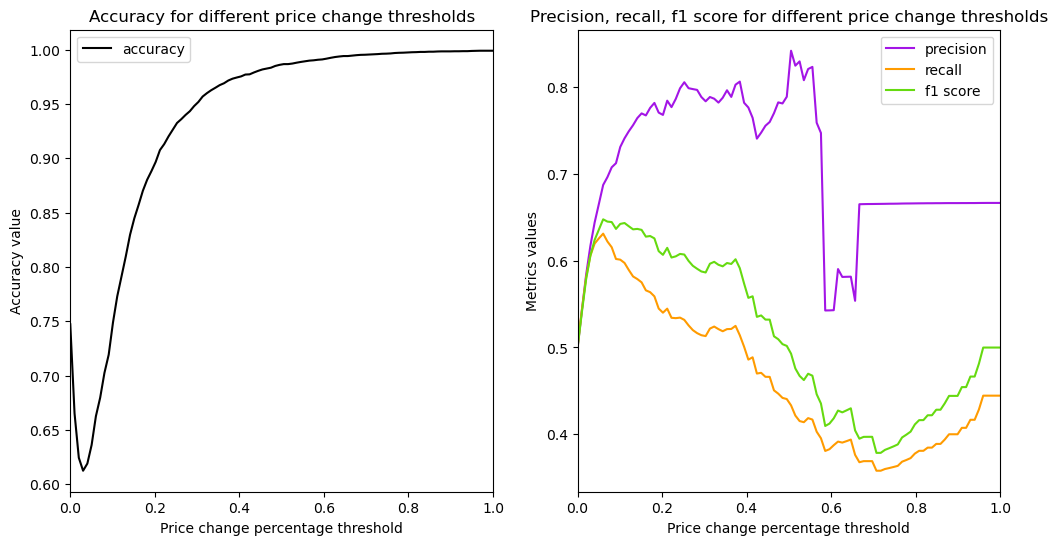

In [39]:
visualizer.plot_metrics_ternary(thresholds, accuracies_ternary, precisions_ternary, recalls_ternary, f1s_ternary)

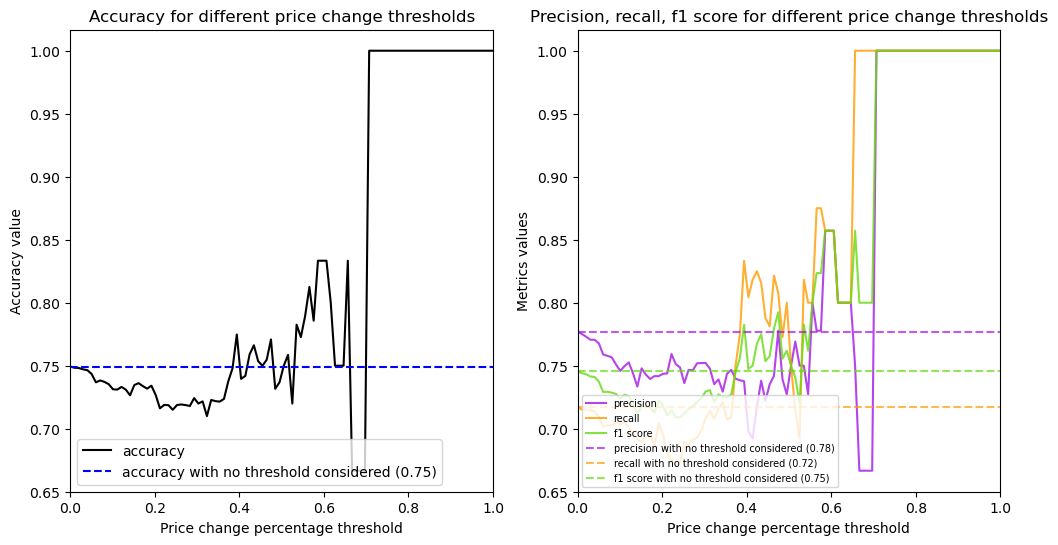

In [40]:
visualizer.plot_metrics_binary(thresholds, accuracies_binary, precisions_binary, recalls_binary, f1s_binary, accuracy_0, precision_0, recall_0, f1_0, "lower left", "lower left")

In [42]:
max_acc, max_acc_idx = data_processor.find_max_and_index(accuracies_binary)
max_pre, max_pre_idx = data_processor.find_max_and_index(precisions_binary)
max_re, max_re_idx = data_processor.find_max_and_index(recalls_binary)
max_f1, max_f1_idx = data_processor.find_max_and_index(f1s_binary)

In [46]:
print(f"Threshold with highest accuracy: {thresholds[max_acc_idx]:.2f}")
print(f"Threshold with highest precision: {thresholds[max_pre_idx]:.2f}")
print(f"Threshold with highest recall: {thresholds[max_re_idx]:.2f}")
print(f"Threshold with highest f1 score: {thresholds[max_f1_idx]:.2f}")

Threshold with highest accuracy: 0.71
Threshold with highest precision: 0.71
Threshold with highest recall: 0.66
Threshold with highest f1 score: 0.71
